In [1]:
##
## VGG16 и VGG19 проверка результативности (реализации взяты с github keras/application):
##                  https://github.com/fchollet/keras/tree/master/keras/applications
##
## 2017-05-20
## maximum on LB => 0.84500
##
## TIF - (,,6) (,,3)
##
## 2017-07-06
##  TIF (64,64,6) - полная схема без выемки 09(cloudy) - то есть 17 признаков
##  
## 2017-07-09
##  TIF (64,64,6) - полная схема по признакам 4,5,6,7
##
## 2017-07-12
##  JPG+TIF (64x64x)==(128x128x) по результатам
##  BatchNarmalizstion не  поднимает результат
##  Наиболее быстрый и адекватный вариант классификационной части dense1024+dense1024
##  Ввод новых вегетационных признаков типа CCCI не приводит к улучшению. Либо также либо чуть хуже
##
## 2017-07-12
##  Проверяю полный прогон на VGG19 (для очистки совести и перехожу на другое)
##
## 2017-07-12
##  Проверил! LB=0.90004. Вставил VGG19 на наборе jpg128 + подставил насильственно веса от imagenet. Работает на train 9 часов.
##  Необходима специализированная препроцессорная обработка для imagenet (RGB-->BGR; минус спец среднее из изображений)
##
## 2017-07-15
##  Вернулся после неудач с другим сетями
##
## 2017-07-15
##
##  Попытка увеличить качество входного материала (resize+equalize) через fit-generator
##
## 2017-07-19
##  Реанимация попытки. Gjkexbkjcm LB = 0.90344
##

In [2]:
import sys,os,datetime,random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm

from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
sys.path.append('../Python')
from helper import paths_input, formImExt, formImHist
from estimate import confusion_matrix, getConfusion, getRocAUC, getProb01, getProbX01, getTh, estimateResult

In [6]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential,save_model,load_model, Model, Input
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Conv2D

from keras.applications.vgg19 import VGG19, preprocess_input

from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [7]:
keras.__version__

'2.0.4'

In [8]:
import keras.losses

In [9]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trDirI = trDirTIF
teDirI = teDirTIF
trWork, teWork = '../Work/Train', '../Work/Test'
trDirI,teDirI, teDirJPG, trWork, teWork

('../Data/train-tif-v2',
 '../Data/test-tif-v2',
 '../Data/test-jpg-v2',
 '../Work/Train',
 '../Work/Test')

In [10]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [11]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [12]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [13]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [14]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [15]:
len(labels_df.tags.unique())

449

In [16]:
#!rm ../Temp/Batch/*.npy

In [17]:
# TODO: сделать все файлы одинаковыми, размера size. Касается последнего, связано с краевыми круговой эффектами выборки в конце.

def generate_batches ( names_tags_df_, dirIn, output_shape, classes=17, ext='.jpg', size=5000, preprocess=True) :
    xx = np.zeros((size,output_shape[0],output_shape[1],output_shape[2]),dtype=np.float32);
    yy = np.zeros((size,classes),dtype=np.uint8);
    
    iijj = 0;
    
    names_tags_df = names_tags_df_
    
    if len(names_tags_df)/size*size<len(names_tags_df) : # выравниваем на размер size добитием len(df)>>size
        len_app = ((len(names_tags_df)/size)+1)*size-len(names_tags_df);
        names_tags_df = names_tags_df.append(names_tags_df_[0:len_app],ignore_index=True);
        print((len(names_tags_df_)/size+1)*size,len(names_tags_df))
        assert((len(names_tags_df)/size)*size==len(names_tags_df))
    
    for ii in range(0,len(names_tags_df),size) :
        yy    = names_tags_df[ii:min(ii+size,len(names_tags_df))].values[:,2:].astype(np.uint8);
        files = names_tags_df[ii:min(ii+size,len(names_tags_df))].image_name.tolist()
        files = [x+ext for x in files]
        if len(files)<size :
            xx = np.zeros((len(files),output_shape[0],output_shape[1],output_shape[2]),dtype=np.float32);
        for i in range(len(files)) :
            nf    = os.path.join(dirIn,files[i])
            xx[i] = formImExt(nf,EqualizeOK=False,resize=(output_shape[0],output_shape[1]))
            iijj += 1
            if (iijj%5000)==0 : print (datetime.datetime.now(),'-->',iijj)
                
        if preprocess : xx    = preprocess_input(xx)
        
        filexx= '../Temp/BatchN/batch-{}-{}x{}x{}-XX.npy'.format(ii,output_shape[0],output_shape[1],output_shape[2])
        fileyy= '../Temp/BatchN/batch-{}-{}x{}x{}-YY.npy'.format(ii,output_shape[0],output_shape[1],output_shape[2])
        np.save(filexx,xx)
        np.save(fileyy,yy)

In [18]:
# Препростройка для быстрой подачи batches
print(datetime.datetime.now())
##generate_batches(labels_df,trDirJPG,(224,224,3))
print(datetime.datetime.now())

2017-07-20 12:15:15.091528
2017-07-20 12:15:15.091853


In [19]:
def get_train (batch_size, n0, ns, dirIn='../Temp/BatchN', size=5000, output_shape=(224,224,3), flip=False, max_fi=40000, debugOK=False):
    
    def get_new_fi (fi, bi, gi) :
        fi_old = fi
        while ((bi+batch_size)>size) or ((gi+1)>=n0+ns) : 
            fi  = (fi + size) if ((gi<(n0+ns))and ((fi+size)<=max_fi)) else (n0/size)*size;
            bi  = (n0-fi) if fi<=n0 else 0
            gi  = fi+bi
        return (fi,bi,gi)
        
    
    assert (batch_size<=size)
    assert ((max_fi/size)>1) or ((n0+batch_size)<=size)
        
    if flip : random.seed()

    while 1:
        
        fi       = (n0/size)*size
        bi       = (n0-fi) if fi<=n0 else 0
        gi       = fi+bi
        
        fi,bi,gi = get_new_fi (fi,bi,gi)
        
        if debugOK : print(datetime.datetime.now(),'g read fi={} bi={} gi={} batch_size={} n0={} ns={} dirIn={}'.
                           format(fi,bi,gi,batch_size,n0,ns,dirIn))
            
        fx = 'batch-{}-{}x{}x{}-XX.npy'
        fy = 'batch-{}-{}x{}x{}-YY.npy'
        xx = np.load(os.path.join(dirIn,fx.format(fi,output_shape[0],output_shape[1],output_shape[2])));
        yy = np.load(os.path.join(dirIn,fy.format(fi,output_shape[0],output_shape[1],output_shape[2])));
        old_fi = fi
    
        while True :
            if ((bi+batch_size)>yy.shape[0]) or ((gi+1)>=n0+ns) :
                fi,bi,gi = get_new_fi (fi,bi,gi)
    
                if debugOK : print(datetime.datetime.now(),'get_train read fi={} bi={} gi={}'.format(fi,bi,gi))
            
                if (fi<>old_fi) :
                    xx = np.load(os.path.join(dirIn,fx.format(fi,output_shape[0],output_shape[1],output_shape[2])));
                    yy = np.load(os.path.join(dirIn,fy.format(fi,output_shape[0],output_shape[1],output_shape[2])));
                    old_fi = fi
                    
                if flip :
                    for i in range(xx.shape[0]) :
                        if random.random()<=flip :
                            for c in range(xx.shape[3]) : xx[i,:,:,c] = cv.flip(xx[i,:,:,c],0);

                if debugOK : print(datetime.datetime.now(),'get_train xx={} yy={} fx={}'.
                                   format(xx.shape,yy.shape,
                                          os.path.join(dirIn,fx.format(fi,output_shape[0],output_shape[1],output_shape[2]))))
                
            
            xxx, yyy, bi, gi = xx[bi:bi+batch_size], yy[bi:bi+batch_size], bi+batch_size, gi+batch_size
            #if debugOK : print(datetime.datetime.now(),
            #                   'get_train get  fi={} bi={} gi={} xxx={} yyy={}'.format(fi,bi,gi,xxx.shape,yyy.shape))
            
            yield (xxx, yyy)

In [20]:
#xx = get_train(128,4873,2000,debugOK=True)
#xx = get_train(batch_size,split,len(validate),debugOK=True)
#for ii in range(4) : xx.next()



In [21]:
if False :
    print(datetime.datetime.now())
    output_shape=(224,224,3)
    for fi in range(0,40497,5000) :
            fx = '../Temp/Batch/batch-{}-{}x{}x{}-XX.npy'
            fy = '../Temp/Batch/batch-{}-{}x{}x{}-YY.npy'
            xx = np.load(fx.format(fi,output_shape[0],output_shape[1],output_shape[2]));
            yy = np.load(fy.format(fi,output_shape[0],output_shape[1],output_shape[2]));
            print (fi,xx.shape,yy.shape)
    print(datetime.datetime.now())

In [22]:
if False :
    for i in range(3) :
        x000 = x00[:,i]
        print(x000.mean(), x000.std(), len(x000[x000<0.1]),x000.argmin())
        #plt.hist(x000[x000<0.0001].ravel(),bins=150); 
        plt.hist(x000.ravel(),bins=150); 
        plt.show(); plt.close()

In [23]:
def fbeta_pred(y_true, y_pred, beta=2.0, OK1=0.2, eps=0.000001, printOK=False):
    beta2 = beta*beta
    yy_true = K.round(y_true)
    #yy_pred = K.round(y_pred+(0.5-OK1))
    yy_pred = K.round(y_pred)
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.0))))
    precision, recall = tp/(tp_fp+eps), tp/(tp+fn+eps) 
    fbeta = (1+beta2)*(precision*recall)/(beta2*precision+recall+eps)
    ##if fbeta>1.0 : fbeta = 1.0;
    if printOK :
        print('ten true ',K.get_value(yy_true))
        #print('ten pred ',y_pred)
        print('ten roun ',K.get_value(yy_pred))
        print(' pre=',K.get_value(precision),' recall=',K.get_value(recall),' tp=',
              K.get_value(tp),' fn=',K.get_value(fn),' tp+fp=',K.get_value(tp_fp))
    return(fbeta)

In [41]:
def loss_beta(y_true, y_pred):
    tp, tp_fp, fn = K.sum((y_pred*y_true)), K.sum(y_pred), K.sum((K.abs(y_pred*(y_true-1.0))))
    precision, recall = tp/(tp_fp+K.epsilon()), tp/(tp+fn+K.epsilon()) 
    result = 5*precision*recall/(4*precision+recall+K.epsilon())
    #pos = K.sum(y_true * y_pred, axis=-1)
    #neg = K.max((1. - y_true) * y_pred, axis=-1)
    #return K.maximum(0., neg - pos + 1.)
    return 1.0-result

In [25]:
K.set_floatx('float32')

In [26]:
sizing = (224,224,3)
input_shape, output_classes, metric = sizing, 17, 'acc'
print(input_shape,output_classes)

(224, 224, 3) 17


In [27]:
model00 = VGG19(weights='imagenet', include_top=True)
for layer in model00.layers :
    if layer.name=='fc1' : fc1 = layer.get_weights()
    if layer.name=='fc2' : fc2 = layer.get_weights()
#model00.summary()
del model00

In [28]:
[x.shape for x in fc1], [x.shape for x in fc2]

([(25088, 4096), (4096,)], [(4096, 4096), (4096,)])

In [29]:
K.clear_session()

model10 = Sequential()
model10.add(BatchNormalization(input_shape=input_shape))

base_model = VGG19(weights='imagenet', include_top=False, pooling=None)

model10.add(base_model)
model10.add(Flatten())


#x = base_model.output

##print(base_model.summary())

##x = GlobalMaxPooling2D()(x) 
#x = Flatten()(x)
initiaze = 'he_normal'
'''
x = Dense(4096, activation='relu',kernel_initializer=initiaze, name='ffcc1')(x)
x = Dropout(0.25)(x)
x = Dense(4096, activation='relu',kernel_initializer=initiaze, name='ffcc2')(x)
x = Dropout(0.25)(x)
'''
'''
x = Dense(2048, activation='relu',kernel_initializer=initiaze, name='ffcc1')(x)
x = Dropout(0.50)(x)
x = Dense(2048, activation='relu',kernel_initializer=initiaze, name='ffcc2')(x)
x = Dropout(0.50)(x)
'''

# and a logistic layer -- let's say we have 200 classes
#predictions = Dense(output_classes, activation='softmax')(x)
#predictions = Dense(output_classes, activation='sigmoid')(x)
model10.add(Dense(output_classes, activation='softmax',name='predictions'))

# this is the model we will train
#model10 = Model(inputs=base_model.input, outputs=predictions)


#for layer in base_model.layers : layer.Tranable = False
'''
flag = ''
for layer in model10.layers :
    if layer.name=='ffcc1' : 
        ffcc = layer.get_weights(); flag+=' fc1'; print(flag,[x.shape for x in ffcc])
        if (ffcc[0].shape==fc1[0].shape) : ffcc[0]+=fc1[0]; flag+=' fc1-0'
        if (ffcc[1].shape==fc1[1].shape) : ffcc[1]+=fc1[1]; flag+=' fc1-1'
        layer.set_weights(ffcc)
    if layer.name=='ffcc2' :
        ffcc = layer.get_weights(); flag+=' fc2'
        if (ffcc[0].shape==fc2[0].shape) : ffcc[0]+=fc2[0]; flag+=' fc2-0'
        if (ffcc[1].shape==fc2[1].shape) : ffcc[1]+=fc2[1]; flag+=' fc2-1'
        layer.set_weights(ffcc)
        
print(flag)
'''

sgd = keras.optimizers.SGD(nesterov=True,decay=1e-3,momentum=0.9)
model10.compile(loss=loss_beta, # 'categorical_crossentropy', #'binary_crossentropy', # 'mean_absolute_error'
              optimizer=sgd, #sgd, #"nadam", #sgd, #"adam", #'rmsprop',
              metrics=['acc',fbeta_pred]) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])

#model10.summary()
print('sgd = {}'.format(sgd.get_config()))

sgd = {'nesterov': True, 'lr': 0.009999999776482582, 'momentum': 0.8999999761581421, 'decay': 0.0010000000474974513}


In [45]:
sgd = keras.optimizers.SGD(nesterov=True,decay=1e-3,momentum=0.9)
model10.compile(loss=loss_beta, # 'categorical_crossentropy', #'binary_crossentropy', # 'mean_absolute_error'
              optimizer=sgd, #sgd, #"nadam", #sgd, #"adam", #'rmsprop',
              metrics=['acc',fbeta_pred]) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])

#model10.compile(loss='categorical_crossentropy', #'binary_crossentropy', # 'mean_absolute_error'
#              optimizer='adam', #sgd, #"nadam", #sgd, #"adam", #'rmsprop',
#              metrics=['acc',fbeta_pred]) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])



In [42]:
#!ls -la ../Temp/TempVGG

In [31]:
if False :
    model10 = load_model('../Data-Keras/Models/model-VGG19-224x224x3-d2048xd2048.h5')
if 0 :
    model10 = load_model('../Temp/TempVGG/vgg19G-jpg-tif-224x224x3-weights.01-acc=0.8812-val_acc=0.8816-.hdf5')
if 0 :
    model10.load_weights('../Data-Keras/Models/model-VGG19-224x224x3-d2048xd2048-weights.h5',by_name=True)

In [33]:
model10.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
vgg19 (Model)                multiple                  20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
predictions (Dense)          (None, 17)                426513    
Total params: 20,450,909
Trainable params: 20,450,903
Non-trainable params: 6
_________________________________________________________________


In [34]:
if False : 
    sweight  = np.zeros(trY.shape[0],dtype=np.float32);
    sweight[:]  = 1.0
    sweight[trY[:,0]==1] = 0.35
    sweight[trY[:,1]==1] = 0.25
    sweight[trY[:,2]==1] = 0.15
    sweight[trY[:,3]==1] = 0.05

In [46]:
epochs     = 10
verbose    = 2
batch_size = 32
stopping   = 10

prefixTemp = 'vgg190-jpg-tif-{}x{}x{}'.format(sizing[0],sizing[1],sizing[2])     

early_stopping = EarlyStopping(monitor='val_loss', patience=stopping,min_delta=0.00001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.0001)

filepath="../Temp/TempVGG/"+prefixTemp+"-weights.{epoch:02d}-acc={"+metric+":.4f}-val_acc={val_"+metric+":.4f}-.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=metric, verbose=1, save_best_only=True, mode='max')

step = 10000
low  = 5000
high = low+step

lb_df = labels_df
##lb_df = labels_df[low:high]
split = len(lb_df)-int(len(lb_df)/5.0)
generate, validate = lb_df[:split], lb_df[split:]

print(datetime.datetime.now())
#hist1  = model10.fit(trX[low:high],trY[low:high],
#hist1  = model10.fit(trX[low:high],trY[low:high],
hist1  = model10.fit_generator( get_train(batch_size,0,len(generate),debugOK=False,flip=0.1),
                    epochs=epochs, 
                    steps_per_epoch=int(len(generate)/batch_size),
                    validation_data=get_train(batch_size,split,len(validate),debugOK=False),
                    validation_steps=int(len(validate)/batch_size),
                    initial_epoch = 3,
                    #### ???? max_queue_size=100,
                    callbacks=[early_stopping,checkpoint, reduce_lr],
                    verbose=verbose)

print(datetime.datetime.now()) #,pp,'fbeta2s=',fbeta2score,fbeta2pred)

2017-07-20 14:40:13.832813
Epoch 4/10
Epoch 00003: acc improved from -inf to 0.01226, saving model to ../Temp/TempVGG/vgg190-jpg-tif-224x224x3-weights.03-acc=0.0123-val_acc=0.0107-.hdf5
2294s - loss: 0.2977 - acc: 0.0123 - fbeta_pred: 0.5113 - val_loss: 0.2979 - val_acc: 0.0107 - val_fbeta_pred: 0.5110
Epoch 5/10
Epoch 00004: acc did not improve
2259s - loss: 0.2976 - acc: 0.0123 - fbeta_pred: 0.5114 - val_loss: 0.2979 - val_acc: 0.0107 - val_fbeta_pred: 0.5110
Epoch 6/10
Epoch 00005: acc did not improve
2262s - loss: 0.2977 - acc: 0.0123 - fbeta_pred: 0.5113 - val_loss: 0.2979 - val_acc: 0.0107 - val_fbeta_pred: 0.5110
Epoch 7/10
Epoch 00006: acc improved from 0.01226 to 0.01229, saving model to ../Temp/TempVGG/vgg190-jpg-tif-224x224x3-weights.06-acc=0.0123-val_acc=0.0107-.hdf5
2259s - loss: 0.2976 - acc: 0.0123 - fbeta_pred: 0.5114 - val_loss: 0.2979 - val_acc: 0.0107 - val_fbeta_pred: 0.5110
Epoch 8/10
Epoch 00007: acc did not improve
2259s - loss: 0.2977 - acc: 0.0123 - fbeta_pred:

In [113]:
#fc1[1].shape, fc1[1][:10], fc2[0][:10], fc2[1][:10], ffcc[0][:10], ffcc[1][:10]
K.floatx(); K.set_floatx('float64')
K.floatx()

'float64'

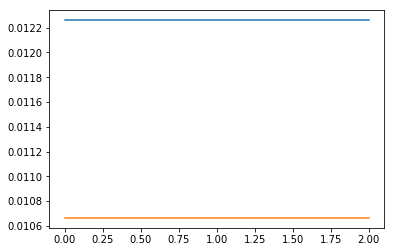

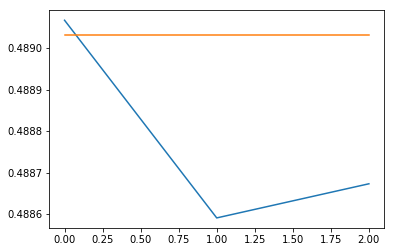

In [36]:
plt.plot(hist1.history['acc']); plt.plot(hist1.history['val_acc']); plt.show()
plt.plot(hist1.history['loss']); plt.plot(hist1.history['val_loss']); plt.show()
plt.close()
#hist1.history

In [37]:
hist1.history

{'acc': [0.012259140316205534, 0.012259140316205534, 0.012259140316205534],
 'fbeta_pred': [0.510830499408509, 0.51140914100549906, 0.51132682634318771],
 'loss': [0.48906727211748657, 0.4885906072355542, 0.48867292189786554],
 'lr': [0.0099999998, 0.0099999998, 0.0099999998],
 'val_acc': [0.01066468253968254, 0.01066468253968254, 0.01066468253968254],
 'val_fbeta_pred': [0.51096921674315887,
  0.51096921674315887,
  0.51096921674315887],
 'val_loss': [0.48903053171104854, 0.48903053171104854, 0.48903053171104854]}

In [47]:
#
#  Построение решения для train массива
#

# train

train = get_train(5000,0,len(labels_df),debugOK=False);

Flag, i, load_size = True, 0, 0;
try : 
    while Flag :
            xx,yy = train.next();
            i, load_size = i+1, load_size+yy.shape[0];
            print(datetime.datetime.now(),'load   : ',i,load_size,xx.shape,yy.shape) #,yy[0],yy[-1])
            assert (xx.shape[0]==yy.shape[0])

            pp   = model10.predict(xx, batch_size=batch_size)
            if (i==1) :
                trP = pp
                trY = yy
            else :
                trP = np.vstack([trP,pp])
                trY = np.vstack([trY,yy])

            if trY.shape[0]>=len(labels_df) : Flag = False;
            print(datetime.datetime.now(),'predict: ',i,trP.shape,trY.shape,Flag) #,trY[0],trY[-1])

except StopIteration as e : Flag = False;
        
finally : train.close();


2017-07-20 19:05:03.306304 load   :  1 5000 (5000, 224, 224, 3) (5000, 17)
2017-07-20 19:06:38.332206 predict:  1 (5000, 17) (5000, 17) True
2017-07-20 19:07:04.366055 load   :  2 10000 (5000, 224, 224, 3) (5000, 17)
2017-07-20 19:08:39.270390 predict:  2 (10000, 17) (10000, 17) True
2017-07-20 19:09:06.190638 load   :  3 15000 (5000, 224, 224, 3) (5000, 17)
2017-07-20 19:10:41.272226 predict:  3 (15000, 17) (15000, 17) True
2017-07-20 19:11:07.049758 load   :  4 20000 (5000, 224, 224, 3) (5000, 17)
2017-07-20 19:12:42.130874 predict:  4 (20000, 17) (20000, 17) True
2017-07-20 19:13:08.822218 load   :  5 25000 (5000, 224, 224, 3) (5000, 17)
2017-07-20 19:14:43.810355 predict:  5 (25000, 17) (25000, 17) True
2017-07-20 19:15:11.310134 load   :  6 30000 (5000, 224, 224, 3) (5000, 17)
2017-07-20 19:16:46.248116 predict:  6 (30000, 17) (30000, 17) True
2017-07-20 19:17:14.396144 load   :  7 35000 (5000, 224, 224, 3) (5000, 17)
2017-07-20 19:18:49.351150 predict:  7 (35000, 17) (35000, 17) 

In [48]:
##%time trP = model10.predict(trX, batch_size=batch_size)
trP01       = getProb01(trP)
th, _       = getTh(trY,trP)
trP01x      = getProbX01(trP,th)

In [49]:
#print(model10.evaluate(trX,trY,verbose=2,batch_size=batch_size))
print(trY.shape)
print(trP.shape)
#print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))
#print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.5, beta=2, average='samples'))
##-------------
print('fbeta_score=',fbeta_score(trY,trP01, beta=2, average='samples'))
print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP01.astype(np.float64))))
##-------------
if trY.shape[1]==17 :
    print('fbeta_score=',fbeta_score(trY,trP01x, beta=2, average='samples'))
    print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP01x.astype(np.float64))))

(45000, 17)
(45000, 17)
fbeta_score= 0.301470344981
fbeta_pred = 0.510213680134
fbeta_score= 0.642528673494
fbeta_pred = 0.748739879978


In [33]:
if False :
    freeze  = ('fc1','fc2','dropout_1','dropout_2','flatten')
    trainOK = ('input_1','predictions')
    for layer in model10.layers :
        #if (layer.name=='fc1') : layer.trainable = False
        #if (layer.name=='fc2') : layer.trainable = False
        if (layer.name in freeze) : layer.trainable = False
        else : layer.trainable = True
        if (layer.name in trainOK) : layer.trainable = True
        layer.trainable = True
        print(layer.name,layer.trainable)      

In [34]:
if True :
    save_model(model10,'../Data-Keras/Models/model-VGG19-224x224x3-d2048xd2048.h5')
    model10.save_weights('../Data-Keras/Models/model-VGG19-224x224x3-d2048xd2048-weights.h5')
    if False : # best 0x90004
        save_model(model10,'../Work/Join-XGB-NET/VGG19-LB=0x90004/model-VGG19-128x128x3-d4096xd4096.h5')
        model10.save_weights('../Work/Join-XGB-NET/VGG19-LB=0x90004/model-VGG19-128x128x3-d4096xd4096-weights.h5')
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIP01-XX.npy',trP01)
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIP-XX.npy', trP)
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIY-YY.npy',trY)

In [35]:
model10.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [36]:
trP[0], trY[0], trP01[0], trP01x[0]

(array([  4.56366807e-01,   4.52337533e-01,   6.06064685e-04,
          8.98498148e-02,   5.49582473e-04,   3.85837993e-05,
          8.01223650e-05,   6.23793603e-05,   1.65109020e-06,
          2.15219679e-05,   3.97033364e-05,   1.96343976e-07,
          1.58212206e-05,   1.37065740e-07,   1.98517318e-05,
          1.81703604e-06,   8.39346467e-06], dtype=float32),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.], dtype=float32),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [139]:
# Результативность

In [50]:
temp = estimateResult(trY,trP01x,printOK=True) # 40000 jpg128 (epoch=40,features=17) VGG19 d4096+d4096 +weights+imnet

0 acc=0.932711111111 roc=0.5 not=3028 yes=0 no=41972 true=41972 all-1-0=(0.0000-1.0000)
1 acc=0.926711111111 roc=0.5 not=3298 yes=41702 no=0 true=41702 all-1-0=(1.0000-0.0000)
2 acc=0.696333333333 roc=0.5 not=13665 yes=0 no=31335 true=31335 all-1-0=(0.0000-1.0000)
3 acc=0.701 roc=0.5 not=13455 yes=31545 no=0 true=31545 all-1-0=(1.0000-0.0000)
4 acc=0.8166 roc=0.5 not=8253 yes=0 no=36747 true=36747 all-1-0=(0.0000-1.0000)
5 acc=0.909755555556 roc=0.5 not=4061 yes=0 no=40939 true=40939 all-1-0=(0.0000-1.0000)
6 acc=0.800488888889 roc=0.5 not=8978 yes=0 no=36022 true=36022 all-1-0=(0.0000-1.0000)
7 acc=0.89 roc=0.5 not=4950 yes=0 no=40050 true=40050 all-1-0=(0.0000-1.0000)
8 acc=0.994755555556 roc=0.5 not=236 yes=0 no=44764 true=44764 all-1-0=(0.0000-1.0000)
9 acc=0.948044444444 roc=0.5 not=2338 yes=0 no=42662 true=42662 all-1-0=(0.0000-1.0000)
10 acc=0.820266666667 roc=0.5 not=8088 yes=0 no=36912 true=36912 all-1-0=(0.0000-1.0000)
11 acc=0.997711111111 roc=0.5 not=103 yes=0 no=44897 true

In [312]:
temp = estimateResult(trY,trP01x,printOK=True) # 40000 jpg128 (epoch=40,features=17) VGG19 d4096+d4096 +weights+imnet LB=0.90004

0 acc=0.970824378073 roc=0.827535509167 not=1181 yes=1786 no=37512 true=39298 all-1-0=(0.6622-0.9929)
1 acc=0.976555744954 roc=0.877590365212 not=949 yes=37271 no=2259 true=39530 all-1-0=(0.9935-0.7616)
2 acc=0.917611601077 roc=0.909720294098 not=3335 yes=10955 no=26189 true=37144 all-1-0=(0.8896-0.9299)
3 acc=0.964376590331 roc=0.949960875432 not=1442 yes=28021 no=11016 true=39037 all-1-0=(0.9856-0.9143)
4 acc=0.937943131006 roc=0.87391779368 not=2512 yes=5728 no=32239 true=37967 all-1-0=(0.7729-0.9749)
5 acc=0.954074952444 roc=0.807677321803 not=1859 yes=2302 no=36318 true=38620 all-1-0=(0.6290-0.9864)
6 acc=0.942711035352 roc=0.901277662688 not=2319 yes=6718 no=31442 true=38160 all-1-0=(0.8324-0.9702)
7 acc=0.928012055634 roc=0.768147534975 not=2914 yes=2520 no=35045 true=37565 all-1-0=(0.5629-0.9734)
8 acc=0.994861533141 roc=0.507152201111 not=208 yes=3 no=40268 true=40271 all-1-0=(0.0144-1.0000)
9 acc=0.990464191309 roc=0.950839323708 not=386 yes=1894 no=38199 true=40093 all-1-0=(

In [50]:
#model.load_weights('../Data-Keras/train-model-2D-2-v2-loop-weights.h5') ## verify load weights from v1 version

In [62]:
def generate_test ( dirIn, output_shape, size=5000, preprocess=True, debugOK=False) :
    
    xx = np.zeros((size,output_shape[0],output_shape[1],output_shape[2]),dtype=np.float32);
    yy = np.array((size,output_shape[0],output_shape[1],output_shape[2]));
    
    iijj = 0;
    
    names_files = np.array(os.listdir(dirIn));
    if debugOK : 
        print('generate_test: names_files={} size={} dirIn={}'.format(len(names_files),size,dirIn))
        names_files = names_files[:1000]
        print(names_files.shape)
    
    for ii in range(0,names_files.shape[0],size) :
        ###if debugOK : print('generate_test: ii={}'.format(ii))
        yy    = names_files[ii:min(ii+size,names_files.shape[0])];
        files = names_files[ii:min(ii+size,names_files.shape[0])].tolist()
        #################files = [x+ext for x in files]
        if len(files)<size :
            xx = np.zeros((len(files),output_shape[0],output_shape[1],output_shape[2]),dtype=np.float32);
        for i in range(len(files)) :
            nf    = os.path.join(dirIn,files[i])
            xx[i] = formImExt(nf,EqualizeOK=False,resize=(output_shape[0],output_shape[1]))
            iijj += 1
            ##if (iijj%5000)==0 : print (datetime.datetime.now(),'-->',iijj)
        if preprocess : xx    = preprocess_input(xx)
        yield xx,yy

In [63]:
#
#  Построение решения для test массива на основе уровней прохождения (эффект почему-то дают)
#    Построенное решение 01 полное с учетом погодных критериев [0,3,9,10]
#        и особенности критерия cloudy (посмотреть и сменить можно в getProbX01)
#        Построение критериев прохождения в getTh
#

# test

test = generate_test(teDirJPG,sizing,size=10000,debugOK=False);
Flag, i, load_size = True, 0, 0;
try : 
    while True :
            xx,yy = test.next();
            i, load_size = i+1, load_size+yy.shape[0];
            print(datetime.datetime.now(),'load   : ',i,load_size,xx.shape,yy.shape,yy[0],yy[-1])
            assert (xx.shape[0]==yy.shape[0])

            pp   = model10.predict(xx, batch_size=batch_size)
            if (i==1) :
                trOP = pp
                trOY = yy
            else :
                trOP = np.vstack([trOP,pp])
                trOY = np.hstack([trOY,yy])

            print(datetime.datetime.now(),'predict: ',i,trOP.shape,trOY.shape,trOY[0],trOY[-1])

except StopIteration as e : Flag = False;
        
finally : test.close();

# Уровни прохождения & решение
trO01   = getProbX01(trOP,th)
######trO01   = getProb01(trOP,th=0.2)



2017-07-20 02:15:21.288719 load   :  1 10000 (10000, 224, 224, 3) (10000,) test_10002.jpg test_19029.jpg
2017-07-20 02:18:30.646932 predict:  1 (10000, 17) (10000,) test_10002.jpg test_19029.jpg
2017-07-20 02:18:56.510001 load   :  2 20000 (10000, 224, 224, 3) (10000,) test_1903.jpg test_28015.jpg
2017-07-20 02:22:02.253519 predict:  2 (20000, 17) (20000,) test_10002.jpg test_28015.jpg
2017-07-20 02:22:26.479803 load   :  3 30000 (10000, 224, 224, 3) (10000,) test_28016.jpg test_37026.jpg
2017-07-20 02:25:35.815766 predict:  3 (30000, 17) (30000,) test_10002.jpg test_37026.jpg
2017-07-20 02:26:00.469369 load   :  4 40000 (10000, 224, 224, 3) (10000,) test_37027.jpg test_9402.jpg
2017-07-20 02:29:05.889105 predict:  4 (40000, 17) (40000,) test_10002.jpg test_9402.jpg
2017-07-20 02:29:30.731536 load   :  5 50000 (10000, 224, 224, 3) (10000,) test_9403.jpg file_18419.jpg
2017-07-20 02:32:40.369371 predict:  5 (50000, 17) (50000,) test_10002.jpg file_18419.jpg
2017-07-20 02:33:24.057833 lo

In [64]:
# Строим результат

In [65]:
trZ = trO01
trOY_old = trOY
trOY_old[0]

'test_10002.jpg'

In [66]:
trOY = trOY_old.tolist(); type(trOY), len(trOY)
trOY = [os.path.splitext(xx)[0] for xx in trOY]; trOY[0]

'test_10002'

In [67]:
temp_list = []
for i in range(trZ.shape[0]) :
    temp = [labels[ii] for ii in range(trZ.shape[1]) if trZ[i,ii]==1];
    temp = ' '.join(temp)
    temp_list.append([trOY[i],temp])
temp_list.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))


In [68]:
temp_list[0:5]

[['test_0', 'haze primary'],
 ['test_1', 'haze primary'],
 ['test_2', 'haze primary'],
 ['test_3', 'haze primary'],
 ['test_4', 'haze primary']]

In [69]:
rrr=pd.DataFrame(temp_list,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-20-02-37-08


In [70]:
rrr.head()

,image_name,tags
0,test_0,haze primary
1,test_1,haze primary
2,test_2,haze primary
3,test_3,haze primary
4,test_4,haze primary
